# Multiples Prediction

In this notebook, a multiple model is produced by using the data-driven approach Surface-Related Multiple Elimination (Verschuur et al., 1992), also known as SRME.

In [1]:
# Import libraries and modules

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import pylops
warnings.filterwarnings('ignore')

### Load data

Our modeled dataset must have the same number of receivers and sourcers and they must be placed along the same positions for this method. By reciprocity, the common shot gathers (CSG) should be the same as their corresponding common channel gathers (CCG).

In [3]:
data = np.load('../data/data.npz')['arr_0']
primaries = np.load('../data/primaries.npz')['arr_0']

In [4]:
true_multiples = data - primaries

In [5]:
# Create plotting parameters

ns = data.shape[0]
nr = data.shape[1]
nt = data.shape[2]

dt = 0.004 # s
dx = 10 # m

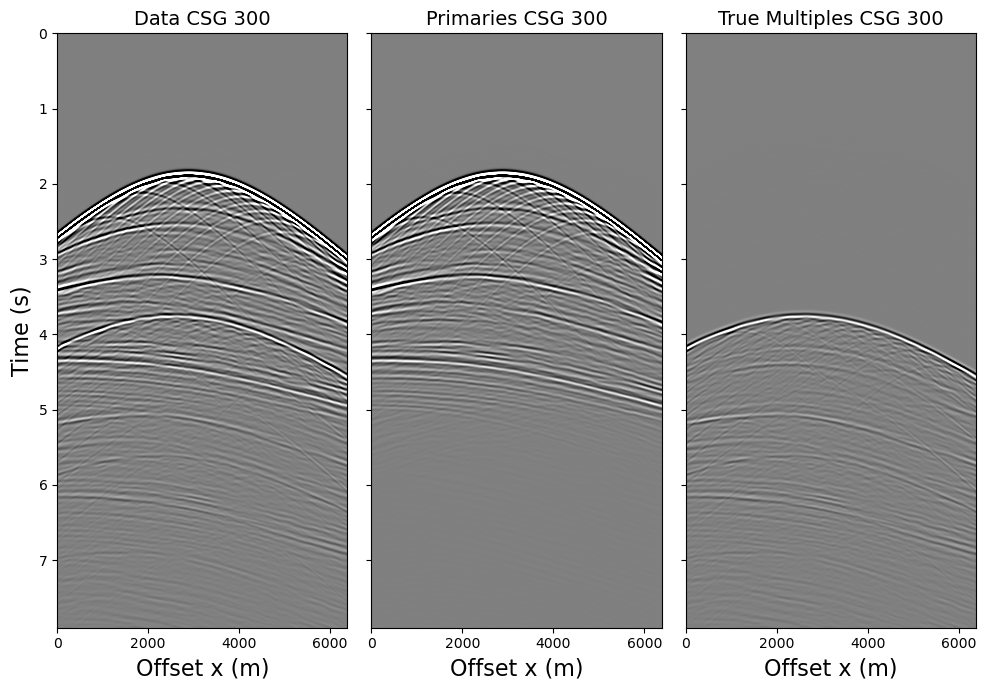

In [6]:
# Plot Common Shot Gathers

vmax = 0.07* np.amax(data)
vmin = -vmax

t0 = 0.0
t1 = t0 + (nt - 1) * dt
xmin = 0
xmax = nr*dx

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)
axs[0].imshow(data[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Data CSG 300',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(primaries[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Primaries CSG 300',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(true_multiples[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'True Multiples CSG 300',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

Check if CCG look the same as CSG.

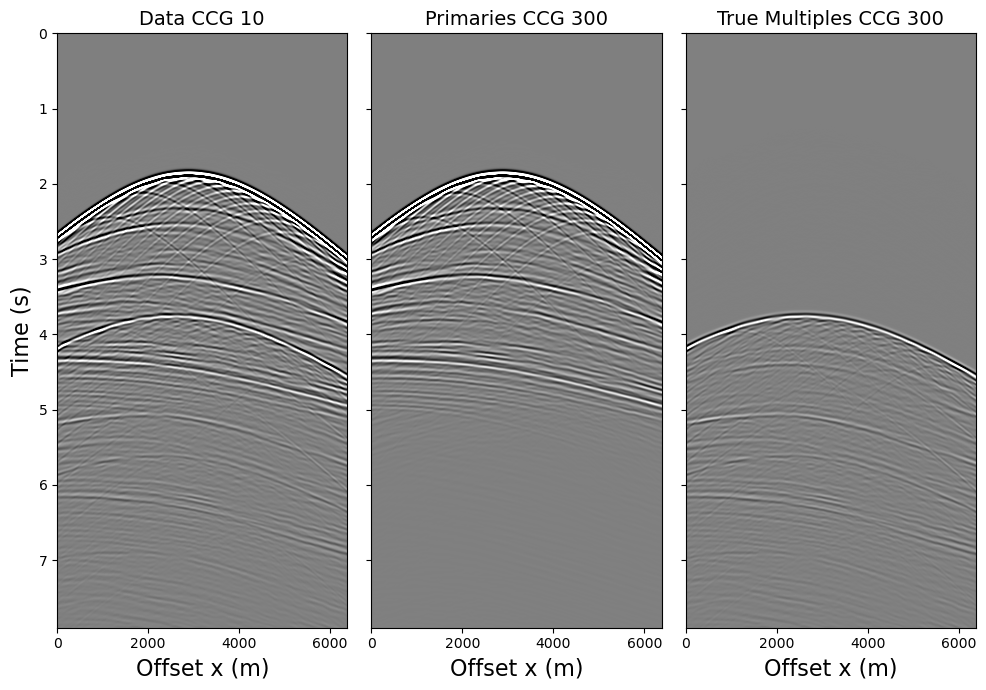

In [8]:
# Plot Common Channel Gathers
xmin = 0
xmax = ns*dx

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)
axs[0].imshow(data[:, 300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Data CCG 10',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(primaries[:, 300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Primaries CCG 300',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(true_multiples[:, 300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'True Multiples CCG 300', fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

### 2D SRME

The following equation represents the 2D SRME (Dragonset et. al, 2010):
$$ \hat{m}(s_k, r_k) = r_0 \sum_{x_k} {d(x_k, r_k)*d(s_k, x_k)} $$
where $r_0$ is the reflectivity coefficient of the free surface (-1 for low angles) and $\hat{m}$ indicates that the prediction will have imperfections, given that the seismic data does not represent the perfect impulse responses of the subsurface.

### Data Pre-processing

In order to avoid wrap-around effects, we will do pre-processing on the data.

- Padding

In [10]:
p = 3  #  divide last axis size by p and pad
data_p = np.concatenate((data, np.zeros((data.shape[0], data.shape[1], data.shape[2]//p))), axis=-1)
data_p.shape

(638, 638, 2634)

- Smooth along interface

In [11]:
smoother = np.ones_like(data_p[0])   # shape of 1 CSG

M = 200  # number of samples before the interface
n = np.arange(0, M)
theta = n * (np.pi/2) / M
semi_hann = np.cos(theta)  # sinusoidal taper

for i in range(smoother.shape[0]):
    smoother[i, p*smoother.shape[1]//(p+1) - M: p*smoother.shape[1]//(p+1)] = semi_hann
    smoother[i, p*smoother.shape[1]//(p+1): smoother.shape[1]] *= 0

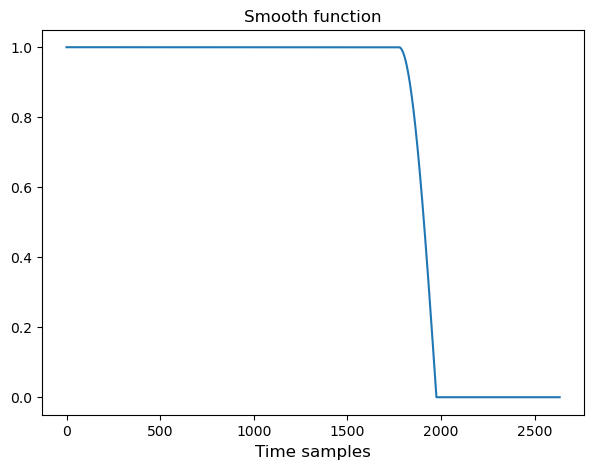

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.plot(smoother[300])
axs.set_xlabel('Time samples', fontsize=12)
axs.set_title('Smooth function')

plt.show()

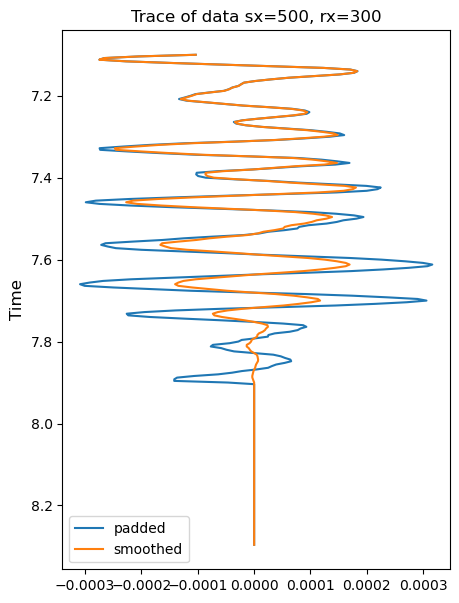

In [27]:
# Apply smooth function to padded data

data_s = np.multiply(data_p, smoother[np.newaxis])

# Plot a trace and compare it with the original 

fig, ax = plt.subplots(1, 1, figsize=(5,7))

sx, rx = 500, 300

y = np.arange(3*smoother.shape[1]//4 - M,3*smoother.shape[1]//4 + 100)*dt

ax.plot(data_p[sx, rx, p*smoother.shape[1]//(p+1) - M: p*smoother.shape[1]//(p+1) + 100], y, label='padded')
ax.plot(data_s[sx, rx, p*smoother.shape[1]//(p+1) - M: p*smoother.shape[1]//(p+1) + 100], y, label='smoothed')
ax.invert_yaxis()
ax.set_ylabel('Time', fontsize=12)
ax.set_title(f'Trace of data sx={sx}, rx={rx}')

plt.legend()
plt.show()

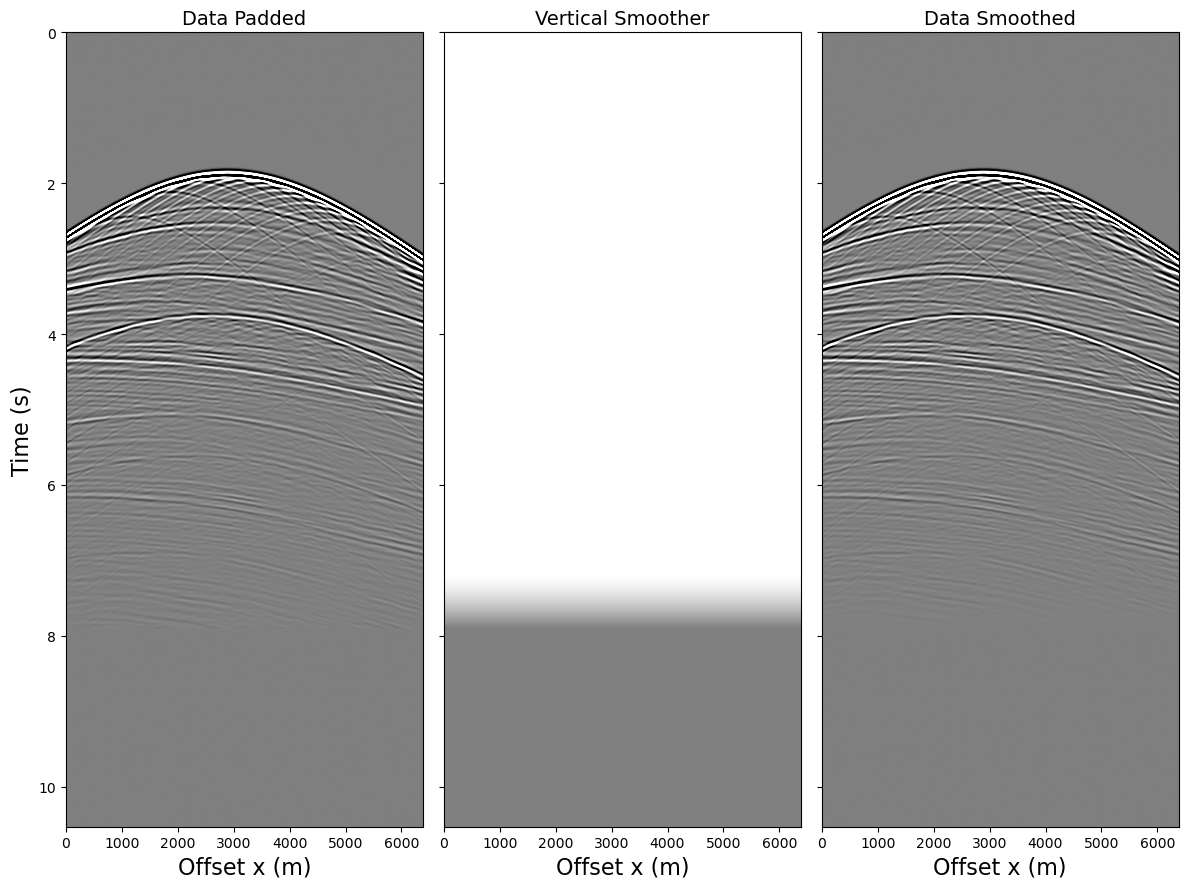

In [38]:
# New plotting parameters 

t0 = 0
t1 = t0 + (data_p.shape[2] - 1) * dt
xmin = 0
xmax = data_p.shape[1]*dx

fig, axs = plt.subplots(1, 3, figsize=(12,9),sharey=True)

axs[0].imshow(data_p[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Data Padded',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)

axs[1].imshow(smoother.T, aspect='auto', vmin=-1, vmax=1, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Vertical Smoother',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)

axs[2].imshow(data_s[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Data Smoothed',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

In [39]:
# Delete non-useful arrays to save memory
del data_p, smoother

- Horizontal Taper (along receiver axis)

In [40]:
h_taper = np.ones_like(data_s[0])

M = 100
n = np.arange(0, M)
theta = n * (np.pi/2) / M
semi_hann_l = np.sin(theta)  # left side
semi_hann_r = np.cos(theta)  # right side

for i in range(h_taper.shape[1]):
    h_taper[:M, i] = semi_hann_l
    h_taper[-M:, i] = semi_hann_r

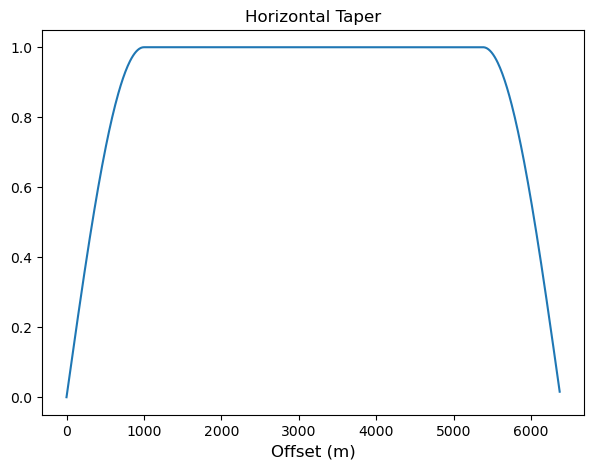

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

x = np.arange(data_s.shape[1])*dx

axs.plot(x, h_taper[:, 1000])
axs.set_xlabel('Offset (m)', fontsize=12)
axs.set_title(f'Horizontal Taper')

plt.show()

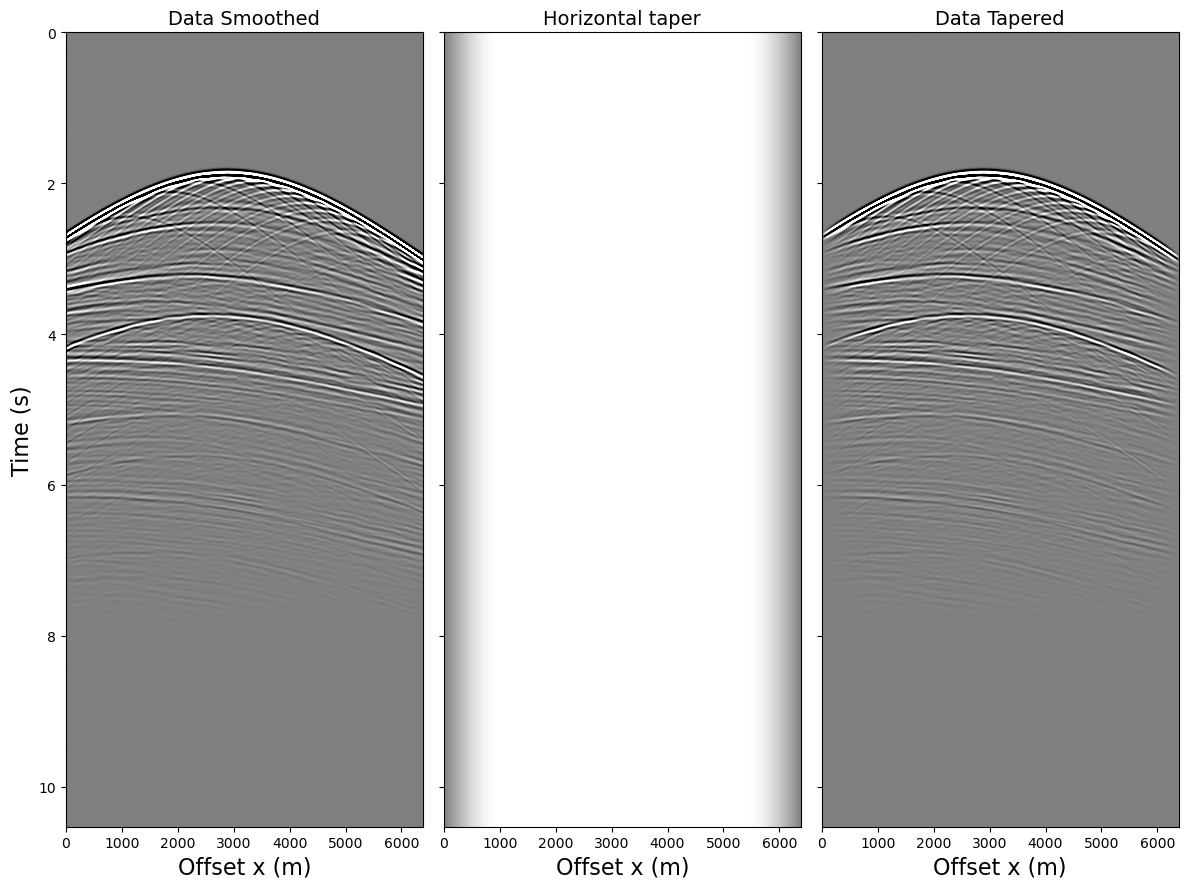

In [42]:
# Apply horizontal taper to smoothed data

data_t = np.multiply(data_s, h_taper[np.newaxis])

# Plot results

fig, axs = plt.subplots(1, 3, figsize=(12,9),sharey=True)

axs[0].imshow(data_s[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Data Smoothed',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)

axs[1].imshow(h_taper.T, aspect='auto', vmin=-1, vmax=1, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Horizontal taper',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)

axs[2].imshow(data_t[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Data Tapered',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

In [43]:
# Delete non-more useful arrays to save memory
del data_s, h_taper

- Transform data into frequency domain

In [19]:
data_fft = np.fft.rfft(data_t, axis=-1)  # time axis

# Cast the type to complex64 to alocate only half of the array size
data_fft = data_fft.transpose(2, 0, 1).astype(np.complex64)

### MDC

To generate the model, we'll employ the Multi-Dimensional Convolution (MDC) function from pylops.

In [24]:
# Create the multi-dimensional convolution operator
MDCop = pylops.waveeqprocessing.MDC(
    data_fft,
    nt=data_t.shape[2],      # number of time samples
    nv=data_t.shape[0],  # number of sources
    dt=dt,      # dt = 0.004 s
    dr=dx,      # dx = 12.5 m
    twosided = False,
    transpose = False
)
MDCop.shape

(1072153896, 1072153896)

In [20]:
# Delete FFT data to save memory
del data_fft

In [ ]:
multiples =  MDCop @ data_t.transpose(2,1,0).ravel()

In [ ]:
# Now we reshape the multiples to match the original data

multiples = multiples.reshape(data_t.shape[2], ns, nr)
multiples = multiples.transpose(1,2,0)
multiples = multiples[:,:, :data.shape[2]]  # removed padded segment
multiples.shape

Load multiples directly from the data folder. We are going to load only shots 299, 300 and 301, considering that these are the only CSGs we will need in the next notebooks.

In [115]:
# multiples = np.load('../data/srme_multiples_raw.npz')['arr_0'][299:302]

### Normalization
Given that the wavelet of the data is convolved with itself several times during the prediction, the SRME multiples will have greater amplitudes. To solve that we apply a scaling the aproximate the predicted multiples as much as possible to the true multiples.

In [116]:
# SRME multiples without normalization

print(' Min of multiples:', np.min(multiples), '\n', 'Max of multiples:', np.max(multiples), '\n', 'Mean of Multiples', np.mean(multiples))

# Compare them withZ true multiples

print('\n Min of true_multiples:', np.min(true_multiples[300]), '\n', 'Max of true_multiples:', np.max(true_multiples[300]), '\n', 'Mean of true_multiples:', np.mean(true_multiples[300]))

 Min of multiples: -5.6727114 
 Max of multiples: 5.387462 
 Mean of Multiples 7.3892406e-06

 Min of true_multiples: -0.013899174518883228 
 Max of true_multiples: 0.019636519253253937 
 Mean of true_multiples: 2.238648455433254e-08


To account for the free surface perfect reflectivity, we also multiply by -1.

In [117]:
# Normalize overestimated multiples 

multiples *= -0.8*np.max(abs(true_multiples[300])) / np.max(abs(multiples))  # We multiply -1 to account for the reflectivity coefficient of the free surface

# Print stats again

print(' Min of multiples:', np.min(multiples), '\n', 'Max of multiples:', np.max(multiples), '\n', 'Mean of Multiples', np.mean(multiples))

 Min of multiples: -0.014919286 
 Max of multiples: 0.015709216 
 Mean of Multiples -2.0462734e-08


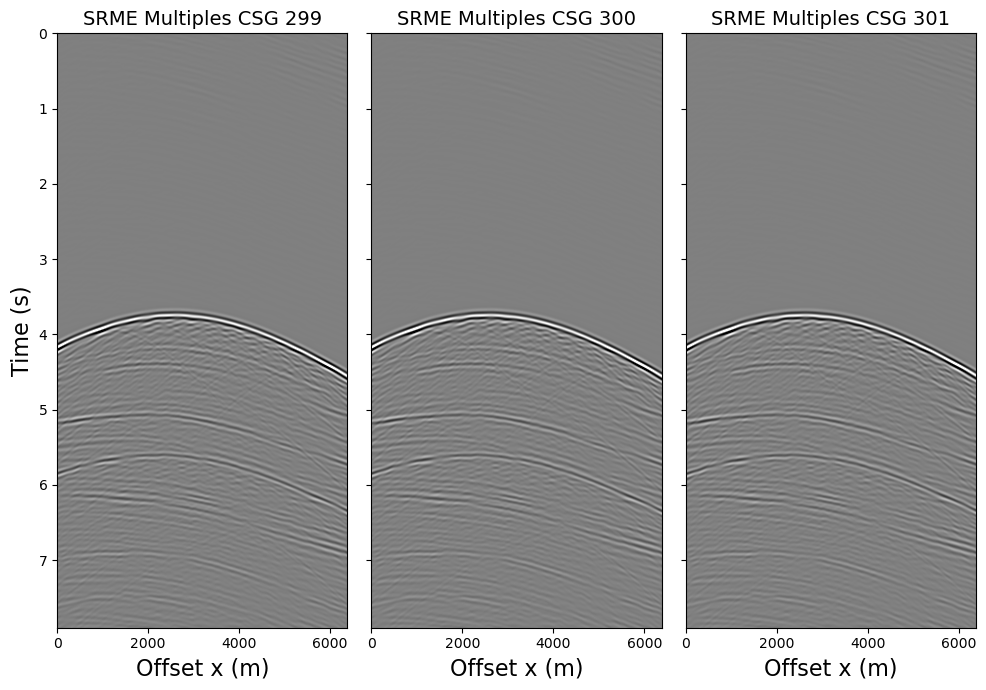

In [118]:
# Randomly plot SRME predicted multiples CSG
t0 = 0
t1 = t0 + (nt - 1)*dt
xmin = 0
xmax = nr*dx

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(multiples[0].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'SRME Multiples CSG 299',fontsize=14)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)

n2 = np.random.randint(0, multiples.shape[0])

axs[1].imshow(multiples[1].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'SRME Multiples CSG 300',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)

n3 = np.random.randint(0, multiples.shape[0])

axs[2].imshow(multiples[2].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'SRME Multiples CSG 301',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

As we can see, there is a lot of noise in the upper part of the shots, so we can simply trim them until 3.5 s and replace with very small values (background noise).

In [119]:
multiples = multiples[:, :, int(3.3/dt):]
multiples = np.concatenate((np.ones((multiples.shape[0], multiples.shape[1], int(3.3/dt)))*1e-13, multiples), axis=-1)
multiples.shape

(3, 638, 1976)

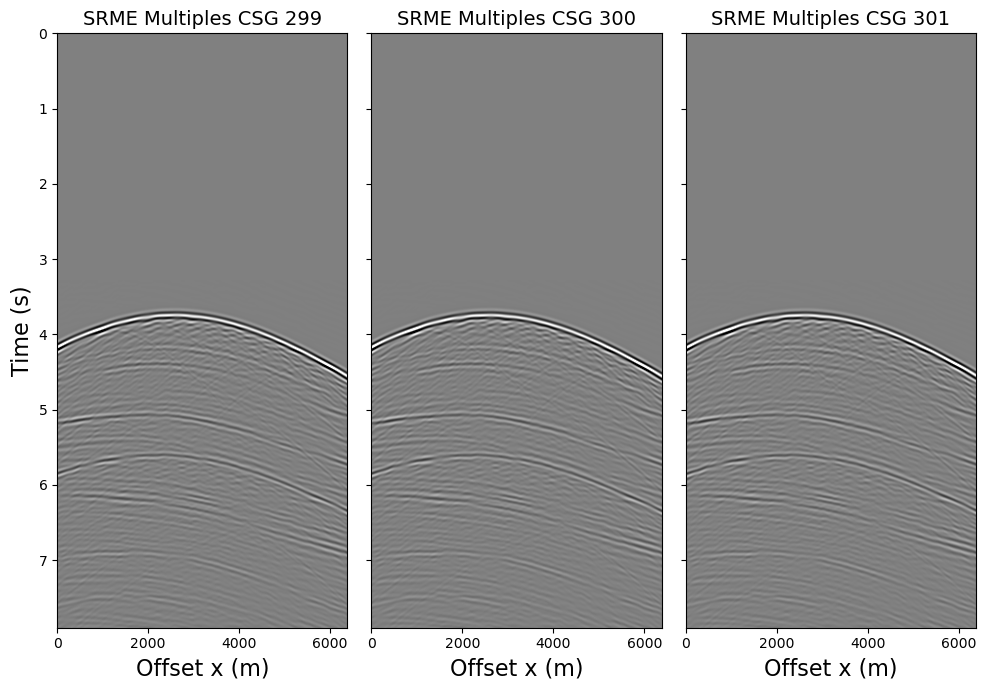

In [120]:
# Now plot the predicted multiples again

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(multiples[0].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'SRME Multiples CSG 299',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)

axs[1].imshow(multiples[1].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'SRME Multiples CSG 300',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)

axs[2].imshow(multiples[2].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'SRME Multiples CSG 301',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

Finally we compare the prediction with the ground truth. Let's pick shot #300.

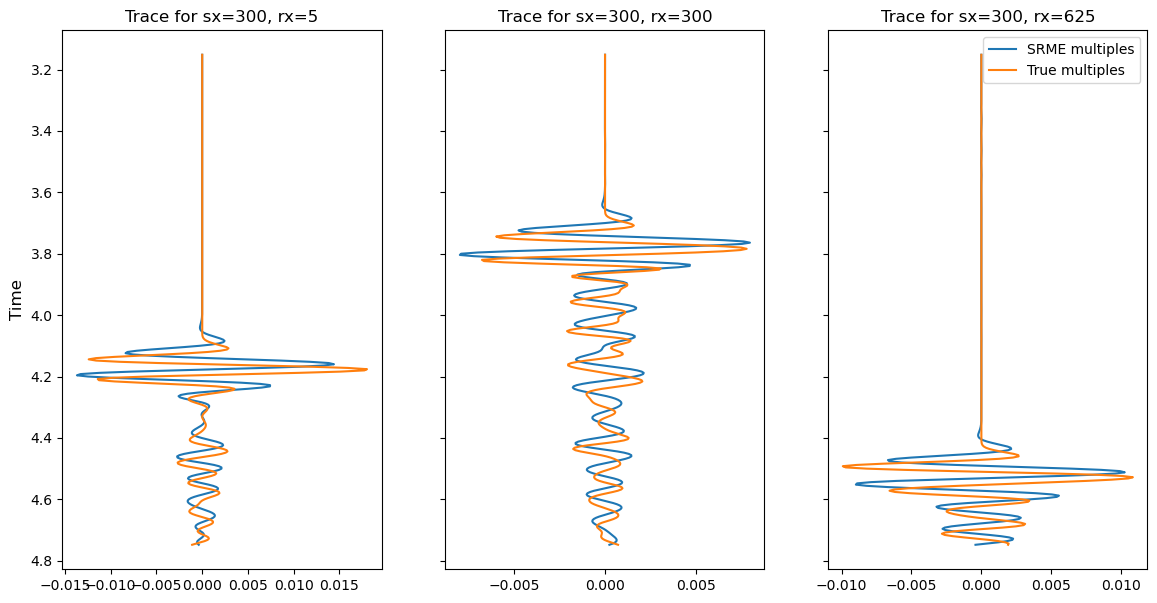

In [121]:
# Plot three traces

fig, axs = plt.subplots(1, 3, figsize=(14,7), sharey=True)

sx, rx = 300, 5

y = np.arange(multiples.shape[2]//2 - 200, multiples.shape[2]//2 + 200)*dt

axs[0].plot(multiples[1, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='SRME multiples')
axs[0].plot(true_multiples[sx, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='True multiples')
axs[0].invert_yaxis()
axs[0].set_ylabel('Time', fontsize=12)
axs[0].set_title(f'Trace for sx={sx}, rx={rx}')

rx = 300

axs[1].plot(multiples[1, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='SRME multiples')
axs[1].plot(true_multiples[sx, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='True multiples')
axs[1].invert_yaxis()
axs[1].set_title(f'Trace for sx={sx}, rx={rx}')

rx = 625

axs[2].plot(multiples[1, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='SRME multiples')
axs[2].plot(true_multiples[sx, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='True multiples')
axs[2].invert_yaxis()
axs[2].set_title(f'Trace for sx={sx}, rx={rx}')

plt.legend()
plt.show()

Relative error between true and estimated multiples: 144.22%


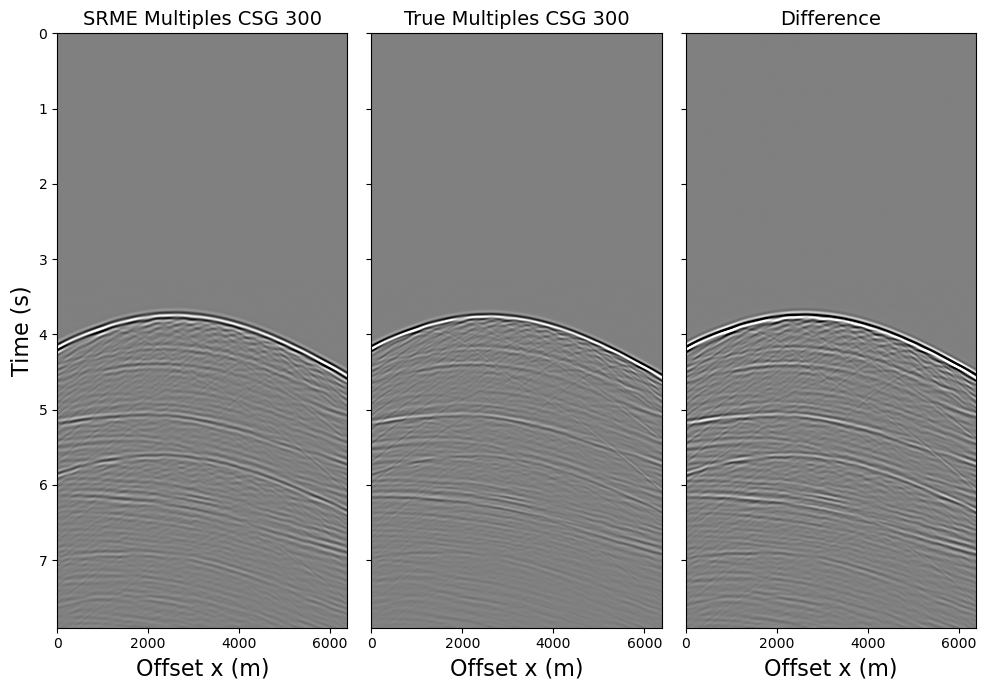

In [122]:
# Compare the complete shots

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(multiples[1].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title('SRME Multiples CSG 300',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)

axs[1].imshow(true_multiples[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title('True Multiples CSG 300',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)

axs[2].imshow((true_multiples[300]-multiples[1]).T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title('Difference',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

# Print relative error betw|een true and estimated multiples
print('Relative error between true and estimated multiples: %.2f%%' % (100*np.linalg.norm(true_multiples[300]-multiples[1])/np.linalg.norm(true_multiples[300])))

plt.tight_layout()

### Shift multiples
As we see, the predicted mulltiples are shifted downward by approximately 75 ms, so we apply now and upward shifting filter. To find the first peak, we need to make sure that the noise in the upper part of the traces in the true multiples is also constant.

In [123]:
true_multiples = true_multiples[:, :, int(3.3/dt):]
true_multiples = np.concatenate((np.ones((true_multiples.shape[0], true_multiples.shape[1], int(3.3/dt)))*1e-13, true_multiples), axis=-1)
true_multiples.shape

(638, 638, 1976)

In [124]:
# Discover how many samples we must shift the traces for shot 300

def find_shift(pred_mult, true_mult):

    # Create list to store the shifts
    shifts = []
    for t in range(pred_mult.shape[0]):
        
        pred_idx = np.where(pred_mult[t] == max(abs(pred_mult[t])))[0]
        true_idx = np.where(true_mult[t] == max(abs(true_mult[t])))[0]
       
        if pred_idx and true_idx:
            shifts.append(true_idx[0]-pred_idx[0])
    
    total_shift = round(np.mean(shifts))
    return total_shift

shift = find_shift(multiples[1], true_multiples[300])
print(f'We need to shift {shift} samples, meaning {shift*dt} s.')

We need to shift 4 samples, meaning 0.016 s.


In [125]:
shift_filt = np.zeros(multiples.shape[2])
shift_filt[shift_filt.shape[0]//2 + shift] = 1  # move samples from the middle point

for i in range(multiples.shape[1]):
    multiples[1, i] = np.convolve(multiples[1,i], shift_filt, 'same')

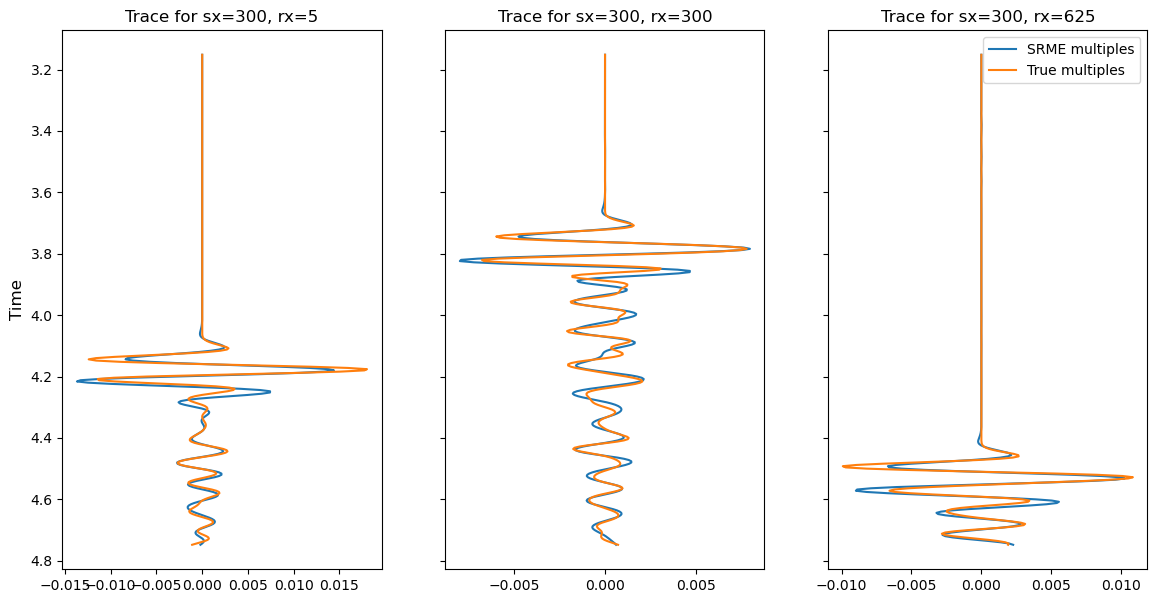

In [126]:
# Plot three traces

fig, axs = plt.subplots(1, 3, figsize=(14,7), sharey=True)

sx, rx = 300, 5

y = np.arange(multiples.shape[2]//2 - 200, multiples.shape[2]//2 + 200)*dt

axs[0].plot(multiples[1, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='SRME multiples')
axs[0].plot(true_multiples[sx, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='True multiples')
axs[0].invert_yaxis()
axs[0].set_ylabel('Time', fontsize=12)
axs[0].set_title(f'Trace for sx={sx}, rx={rx}')

rx = 300

axs[1].plot(multiples[1, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='SRME multiples')
axs[1].plot(true_multiples[sx, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='True multiples')
axs[1].invert_yaxis()
axs[1].set_title(f'Trace for sx={sx}, rx={rx}')

rx = 625

axs[2].plot(multiples[1, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='SRME multiples')
axs[2].plot(true_multiples[sx, rx, multiples.shape[2]//2 - 200: multiples.shape[2]//2 + 200], y, label='True multiples')
axs[2].invert_yaxis()
axs[2].set_title(f'Trace for sx={sx}, rx={rx}')

plt.legend()
plt.show()

Relative error between true and estimated multiples: 47.64%


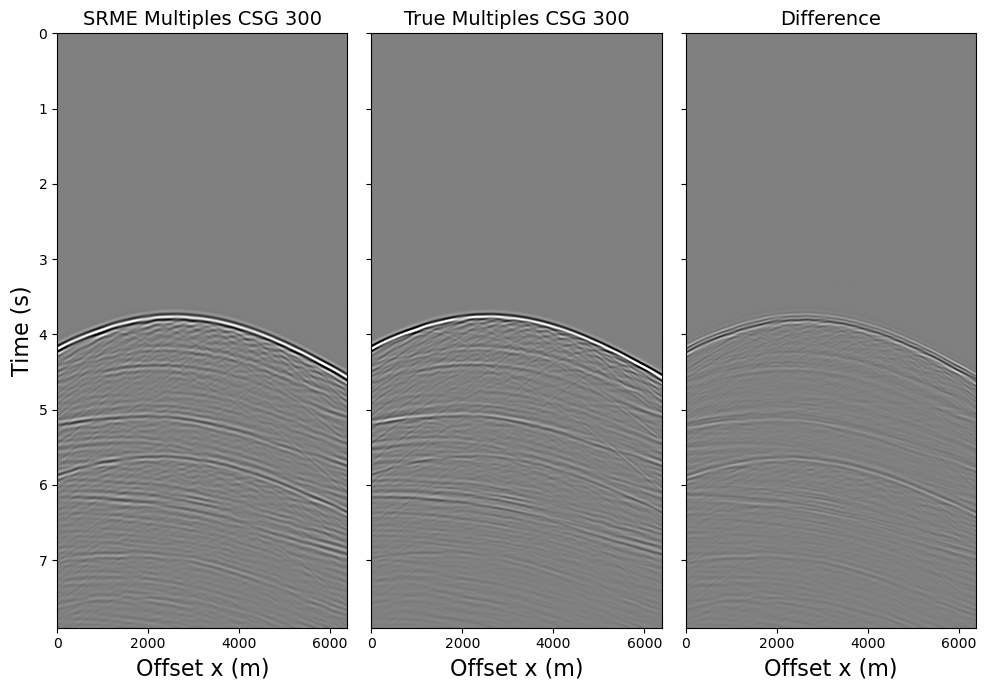

In [127]:
# Compare the complete shots

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(multiples[1].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title('SRME Multiples CSG 300',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)

axs[1].imshow(true_multiples[300].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title('True Multiples CSG 300',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)

axs[2].imshow((multiples[1]-true_multiples[300]).T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title('Difference',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

# Print relative error between true and estimated multiples
print('Relative error between true and estimated multiples: %.2f%%' % (100*np.linalg.norm(multiples[1]-true_multiples[300])/np.linalg.norm(true_multiples[300])))

plt.tight_layout()

There is a clear stronger alignment between prediction and ground truth. We can proceed saving our SRME multiples. Due to the fact that we will utilize only the shots 299, 300 and 301 for the upcoming notebooks, we will only shift these shots and then saved them in a npz file.

In [128]:
for i in range(multiples.shape[1]):
    multiples[0, i] = np.convolve(multiples[0,i,:], shift_filt, 'same')
    
print('Relative error between true and estimated multiples shot 299: %.2f%%' % (100*np.linalg.norm(true_multiples[299]-multiples[0])/np.linalg.norm(true_multiples[299])))

for i in range(multiples.shape[1]):
    multiples[2, i] = np.convolve(multiples[2,i,:], shift_filt, 'same')

print('Relative error between true and estimated multiples shot 301: %.2f%%' % (100*np.linalg.norm(true_multiples[301]-multiples[2])/np.linalg.norm(true_multiples[301])))

Relative error between true and estimated multiples shot 299: 47.63%
Relative error between true and estimated multiples shot 301: 47.65%


In [130]:
# Save shifted predicted multiples in an npz file

np.savez('../data/srme_multiples.npz', multiples)